# Distance Ladder I - Resolved Galaxies

To create a distance ladder for our universe, we need to calculate the distances to nearby galaxies that have resolved stars. We can do this by utilising two equally valid and *independent* methods: the period-luminosity relationships we found earlier, and 'Main Sequence' fitting of HR diagrams. 

## Period-Luminosity Distance Estimation

As in the previous workbooks, I'll start by importing the names of resolved galaxies we've identified. 

In [1]:
import os 

datapath = 'Sim Data (Clusters; 800, Seed; 2639)' # all of the data is within a folder in this .ipynb file's directory
GalaxyNames = []
for clusterFile in os.listdir(datapath + '/Star Clusters'):
    GalaxyNames.append(clusterFile[:-4]) # this gets the name of the cluster, without the `.txt' file extension

To begin with, I'll look at the period-luminosity relationship as a means of distance estimation. That is, for all of the variable stars in a galaxy, I'll estimate their intrinsic luminosity and compare that against their observed flux (via the inverse square law) to calculate distance. 

The below code block is quite large, so I'll explain the rationale before we jump into the code. For a given galaxy, we need to identify which stars are variable, and then calculate their variability periods via a Lomb-Scargle periodogram. We can then put those periods into the period-luminosity relationships we found in an earlier workbook to yield the approx. *intrinsic luminosity* of each star. We then compare that with that stars observed flux and obtain the distance to that star as a result. Finally, we can use a statistical trick to ignore outlying data and take the average of the remaining (valid) data points to obtain an estimate for a galaxys distance.

In [25]:
import pandas as pd
import numpy as np
from astropy.timeseries import LombScargle

freqs = np.linspace(1/120, 0.45, 1000)
distance_data = pd.DataFrame({'Name': GalaxyNames})

PL_dists = np.zeros(len(GalaxyNames))
for num, name in enumerate(GalaxyNames): # iterate over the identified galaxies
    galaxdata = pd.read_csv(datapath + f'/Star Clusters/{name}.txt', delimiter=' ')
    # now to isolate the variable stars
    variables = galaxdata['Variable?']
    variableindexes = [i for i, x in enumerate(variables) if x == 1]
    variablenames = galaxdata['Name'][variableindexes].to_numpy()
    periods = np.zeros(len(variablenames)) # initialise
    # now calculate the period of each variable star via LS periodogram
    for i, star in enumerate(variablenames):
        photometryData = pd.read_csv(datapath + f"/Variable Star Data/{star}.txt", delimiter=' ')
        
        time, flux = photometryData['Time'], photometryData['NormalisedFlux'] # just extract the columns as variables
        LS = LombScargle(time, flux) # initialize a Lomb-Scargle fitting
        power = LS.power(freqs) # calculate LS power 
        bestfreq = freqs[np.argmax(power)] # which frequency has the highest Lomb-Scargle power?
        pred = LS.model(time, bestfreq) # make a sine wave prediction at the best frequency
        periods[i] = 1 / bestfreq # add each period to the list
        
    intr_lumin = np.zeros(len(periods)) # initialise
    lumin_err = np.zeros(len(periods))
    # time to work out intrinsic luminosities via the PL relations
    for i, period in enumerate(periods): 
        if 20 <= period <= 35:
            intr_lumin[i] = 10**(-0.086 * period + 28.25)
        if 35 <= period <= 55:
            intr_lumin[i] = 10**(-0.087 * period + 33.72)
        elif 80 <= period <= 110:
            intr_lumin[i] = 10**(-0.087 * period + 34.35)
            
    # now to finally compare intr_lumin against the fluxes to obtain distances
    greenFluxes = galaxdata['GreenF'][variableindexes].to_numpy()
    distances = []
    if len(intr_lumin) > 10: # we only want to look at galaxies with reasonably high sample size of variables
        for i, lumin in enumerate(intr_lumin):
            if lumin > 0: # this is to avoid noisy data
                distance_m = np.sqrt(lumin / (4 * np.pi * greenFluxes[i]))
                distance_pc = distance_m / (3.086 * 10**16)
                distances.append(distance_pc)
        # now we need to remove any (inevitable) outliers from the data
        q1, q3 = np.percentile(distances, [25, 75], interpolation='midpoint')
        IQR = q3 - q1
        # the below checks if the data point is within 2.7 standard deviations of the mean
        upper = q3 + 1.5*IQR
        lower = q1 - 1.5*IQR
        # now we only care about data within 2.7 STDs 
        distances = [dist for dist in distances if lower <= dist <= upper]
    PL_dists[num] = np.mean(distances)

In [26]:
distance_data['PL_distance'] = PL_dists

Now for HR fitting

In [27]:
print(distance_data)

                    Name   PL_distance
0     X000.7-Y065.4-N610  23166.527455
1    X001.3-Y063.9-N1640  14820.848927
2     X002.2-Y076.6-N613   6800.865201
3     X002.4-Y065.4-N781  23709.239488
4     X002.6-Y057.3-N842   7480.182488
..                   ...           ...
388   X354.8-Y077.7-N708  19100.066343
389   X355.3-Y074.1-N915   7200.860679
390   X355.9-Y077.4-N898   5584.375784
391   X356.2-Y076.6-N842  18124.891216
392   X356.7-Y081.1-N656  17509.515881

[393 rows x 2 columns]


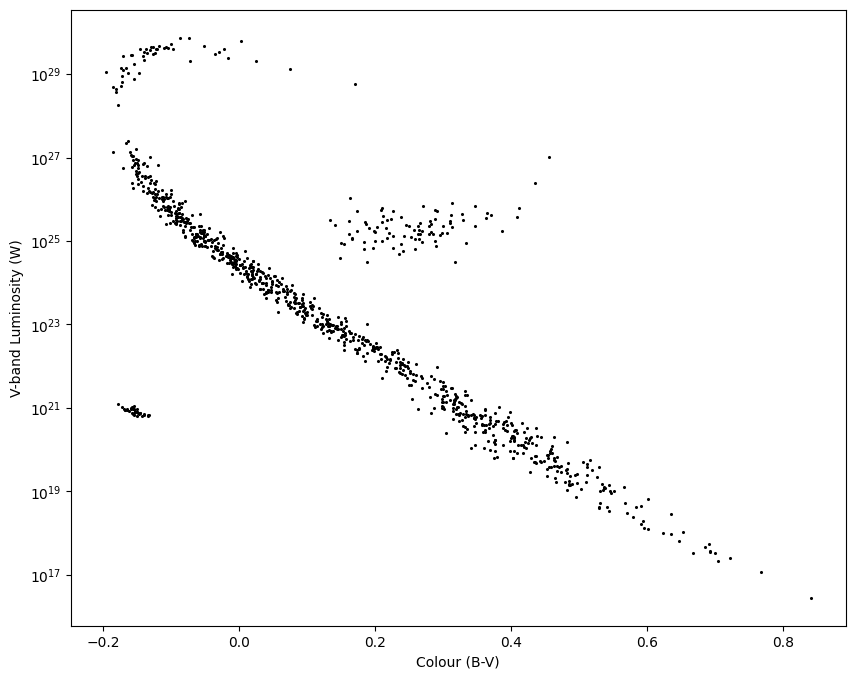

In [5]:
import matplotlib.pyplot as plt

allstardata = pd.read_csv(datapath + '/All Star Data.txt', delimiter=' ')    # read the data from the .txt file into a dataframe

parallax = allstardata['Parallax']    # get the parallax of the stars

localindex = [i for i, x in enumerate(parallax) if x > 0.007]
localVflux = np.array(allstardata["GreenF"])[localindex]
localBflux = np.array(allstardata["BlueF"])[localindex]
BV = np.log10(localVflux / localBflux) # B-V colour index 

localVlumin = localVflux * 4 * np.pi * (1 / np.array(allstardata["Parallax"][localindex]) * 3.086 * 10**16)**2

fig = plt.figure(figsize=(10, 8))   # make a figure to plot stuff on
ax = fig.add_subplot(1, 1, 1)    # and add an axis so we can plot stuff on the figure
ax.scatter(BV, localVlumin, s=1.5, c='k')
ax.set_yscale('log'); ax.set_xlabel('Colour (B-V)'); ax.set_ylabel('V-band Luminosity (W)');

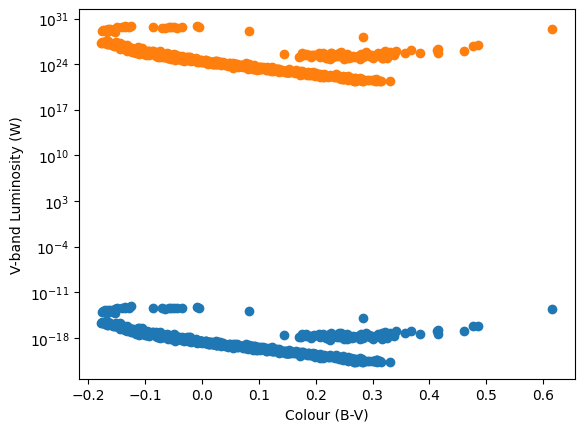

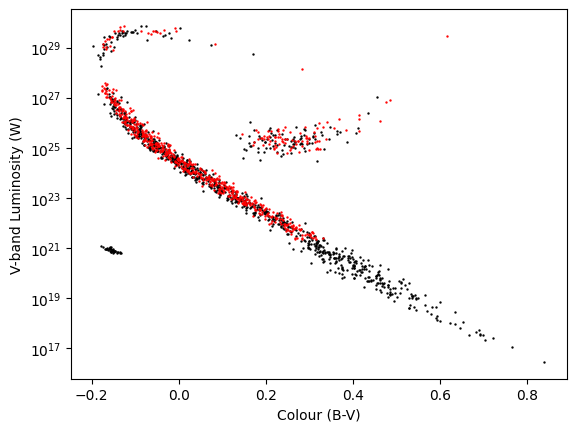

In [23]:
MS_dist = np.zeros(len(GalaxyNames))
for num, name in enumerate(GalaxyNames):
    galaxdata = pd.read_csv(datapath + f'/Star Clusters/{name}.txt', delimiter=' ')
    galaxVflux = np.array(galaxdata["GreenF"])
    galaxBflux = np.array(galaxdata["BlueF"])
    galaxBV = np.log10(galaxVflux / galaxBflux) # B-V colour index 
    
    offset = max(np.log10(localVlumin)) - max(np.log10(galaxVflux))
    dist_m = np.sqrt(10**offset / (4 * np.pi))
    dist_pc = dist_m / (3.086 * 10**16)
    
    MS_dist[num] = dist_pc
    
    if num == 20:
        fig, ax = plt.subplots()
        ax.scatter(galaxBV, galaxVflux)
        ax.set_yscale('log'); ax.set_xlabel('Colour (B-V)'); ax.set_ylabel('V-band Luminosity (W)');

        ax.scatter(galaxBV, galaxVflux * 10**offset)
        
        fig, ax = plt.subplots()
        ax.scatter(BV, localVlumin, s=0.5, c='k')
        ax.scatter(galaxBV, galaxVflux * 10**offset, s=0.5, c='r')
        ax.set_yscale('log'); ax.set_xlabel('Colour (B-V)'); ax.set_ylabel('V-band Luminosity (W)');
        
    

In [24]:
print(MS_dist)

[27581.90645689  6415.99407491  7548.52317034 24263.99202446
  7680.24513922 25235.29942909  6527.47088652  6588.89120251
  6536.46189752  5516.71979236  7486.84559695 29028.59806626
 31399.31499396 29624.50448616 31497.14413332  7466.6199528
 31297.44553339 31916.14769409  6452.51601709  6496.29206875
 30795.49559735 33233.71713006 30671.40939179 32495.28871524
 30046.43264451 31280.15207833 28634.31650865 27632.81754394
 34933.699812   32999.38515994 30583.35953445 32095.95839967
 33989.99541308 28084.40110936 36948.82986038 27485.94567722
 25430.66563789 25595.40583979 25781.3379491  38562.08366783
 33594.76756399 32087.96139982 30611.08278492 26869.26017934
 27902.17654424 30521.25660815 29343.38365558 26521.0013142
 34082.21711665 26514.98543541  2805.05182751 27504.38643452
 31819.57029299  3176.51445984 32224.72906085 27942.55979292
 28188.59741586 26480.4733999  28469.12437024 26484.96732838
 30404.97604593 26596.54696177 31517.3249101  25974.20802175
 27891.67054705 24927.3696